# 监督学习 Supervised Learning

引入科学计算和绘图相关包

In [7]:
import math
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
# 引入绘图包
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

引入波士顿房价数据

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

我们仅使用ZN（超过25000平方英尺的居住用地区域占比），RM（平均房间数）和Price（按1000美元计的房价中位数）三个指标。

绘制平均房间数和房价中位数的散点图

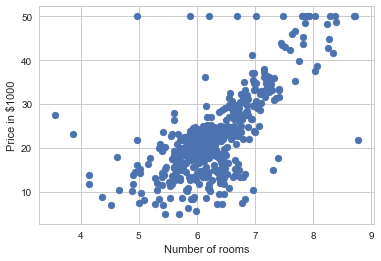

In [3]:
X, Y = DataFrame(data=boston.data, columns=boston.feature_names)[["ZN", "RM"]], DataFrame(data=boston.target, columns=["Price"])
plt.scatter(X["RM"], Y)
plt.xlabel("Number of rooms")
plt.ylabel("Price in $1000")

为了方便描述，我们这里引入一些符号。$x^{(i)}$ 用来表示输入变量，比如这里的平均房间数，它也被称为**特征features**。$y^{(i)}$ 用来表示输出变量，或我们希望预测的**目标target**变量。一对 $(x^{(i)}, y^{(i)})$ 称为一个**训练样本training example**，而我们将使用的 $m$ 个训练样本 $\{(x^{(i)}, y^{(i)});i=1,...,m\}$ 的集合称为**训练集training set**。注意这里的上标 $(i)$ 是对训练集的一个索引编号，不是幂运算。我们用 $\chi$ 表示输入空间，$\gamma$ 表示输出空间。在这个例子中 $\chi=\gamma=\mathbb{R}$

正式地定义监督学习：给定一个训练集，我们希望学习到一个函数 $h: \chi \rightarrow \gamma$，使得 $h(x)$ 可以很好地预测 $y$。由于历史原因，函数 $h$ 被称为**假设hypothesis**。

当我们希望预测的目标变量是连续型变量时，比如这里的房价，我们称这是一个**回归Regression**问题。当 $y$ 仅仅只取少数离散值时，我们称这是一个**分类Classification**问题。

# 线性回归 Linear Regression

包括以下内容：
    1. 最小二乘法 LMS algorithm
    2. 正规方程 The normal equations
    3. 概率诠释 Probabilistic interpretation
    4. 局部加权线性回归 Locally weighted linear regression

In [4]:
# 预览数据
print(X.join(Y).head())

     ZN     RM  Price
0  18.0  6.575   24.0
1   0.0  6.421   21.6
2   0.0  7.185   34.7
3   0.0  6.998   33.4
4   0.0  7.147   36.2


对于这个数据集，$x$ 是一个$\mathbb{R}^2$上的二维向量。例如 $x_1^i$ 是训练集中第 $i$ 个居住区域的超过25000平方英尺的居住用地区域占比，$x_2^i$是该区域的平均房间数。

要进行监督学习，我们需要首先决定如何来表示假设/函数 $h$。较为简单的情况下，我们选取 $x$ 的线性函数来预测 $y$ ：
$$ h_\theta(x) = \theta_0 + \theta_1x_1 + \theta_2x_2 $$
这里，$\theta_i$称为**参数parameters**（有时也称为**权重weights**），通过这组参数，我们将 $\chi$ 线性映射到 $\gamma$。在不引发误解的情况下，我们将 $h_\theta(x)$简写为 $h(x)$。习惯上，我们设 $x_0=1$ （称为**截距项intercept term**）,这样
$$ h(x) = \sum_{i=0}^n \theta_ix_i = \theta^Tx $$
对于右式，我们将 $\theta$ 和 $x$ 看做向量，$n$ 是特征数量（不包括 $x_0$ )

这样，给定训练集，我们需要挑选，或者说学习出参数 $\theta$ 的值。一个直观的方法是使 $h(x)$ 尽量接近 $y$，至少对于训练集来说，尽量地接近。为了更正式地定义“接近”，我们定义**成本函数cost function**：
$$ J(\theta) = \frac{1}{2}\sum_{i=1}^m (h_{\theta}(x^{(i)}) - y^{(i)})^2$$

## 1. 最小二乘法 Linear Regression

我们希望挑选出使 $J(\theta)$ 最小化的值 $\theta$。一种搜索算法的思路是，我们随机猜测一个 $\theta$，然后重复地改变 $\theta$ 使得 $J(\theta)$ 不断变小，直到 $\theta$ 收敛到某个值使得 $J(\theta)$ 取得最小值。

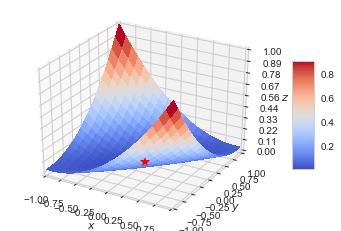

In [17]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
xmin, xmax, xstep = -1, 1, 0.1
ymin, ymax, ystep = -1, 1, 0.1
x = np.arange(xmin, xmax + xstep, xstep)
y = np.arange(ymin, ymax + ystep, ystep)
x, y = np.meshgrid(x, y)
f = lambda x, y: 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y
z = f(x, y)
minima = np.array([0, 0])
minima_ = minima.reshape(-1, 1)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.plot(*minima_, f(*minima_), 'r*', markersize=10)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()